##### --------------------------------------------

# PRESENTATION
##### --------------------------------------------


Le but de ce projet est de développer un modèle de classification multiple, à partir d'images de radiographies pulmonaires.

# Partie 1: Data-preprocessing

# Partie 2: Modélisation
##### Modélisation 1: CNN Lenet
##### Modélisation 2: CNN personnalisé
##### Modélisation 3: Transfer Learning avec EfficientNetB5
##### Modélisation 4: Extraction de feature avec InceptionV3 et Xgboost
##### Modélisation 5: Augmentation d'image avec VGG16

### Chemin d'accès au radiographie

Le premier chemin permet d'accéder aux radiographies téléchargées sur le Kaggle.
Le second chemin permet d'accéder aux radiographies ayant bénéficiées d'un traitement morphologiques. 

In [7]:
# chemin d'accès au radiographies brutes
old_path=r"C:\Users\cedric\Desktop\archive\COVID-19 Radiography Database"

# chemin d'accès au radiographies post-traitées
new_path=r"C:\Users\cedric\Desktop\Projet"

### Importation des bibliothèques et package

In [8]:
import io
import os
import cv2
import glob
import random
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
from math import floor
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# réduction de dimension
from matplotlib import offsetbox
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap
from mpl_toolkits.mplot3d import Axes3D
from sklearn.feature_selection import SelectPercentile

# pre-processing
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

# évaluation
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# architecture deep learning
from tensorflow import keras
from keras.models import Sequential 
from keras.layers.convolutional import Conv2D 
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Flatten, Dropout, Dense, GlobalAveragePooling2D, InputLayer, Input

# métrique deep learning
from tensorflow.keras import callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# transfer learning et extraction de feature
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import preprocess_input

# estimateur pour classification 
from xgboost import XGBClassifier


# Pour ignorer les warning
import warnings
warnings.filterwarnings("ignore")

##### ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# PARTIE 1: DATA-PREPROCESSING/Traitement des radiographies
##### ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Lors de la phase de datavisualisation, l'équipe projet à constaté que les radiographies de type COVID ne présentaient pas de bords noirs latéraux, tandis que les radiographies de type Normal et Pneumonie en présentaient.  
L'application d'un traitement d'image peut atténuer le biais induit par la présence de bords noirs verticaux.
L'idée sous-jacente, est de réaliser un «zoom» sur les radiographie NORMAL et PNEUMONIE.
La solution retenue, préconise l'élimination des bords latéraux, inférieurs et supérieurs, afin de se focaliser sur l'information utile, les poumons. La partie basse des radiographies, correspondant aux coupoles diaphragmatiques est éliminée car peu porteuse d'informations. Il en est de même pour la partie haute des radiographies, correspondant à la région du corps située au dessus des clavicules.

## Effet de la transformation morphologique sur les radiographies de type "Normal"

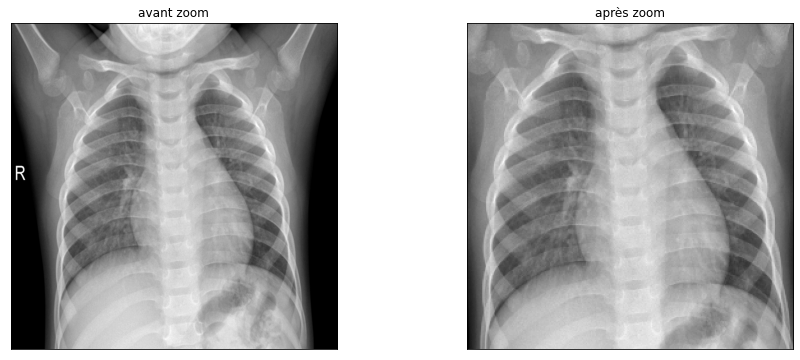

In [3]:
liste_normal = glob.glob(old_path+"/Normal/*")

plt.figure(figsize=(15,6))

plt.subplot(121)
radio_normal=plt.imread(liste_normal[(floor(random.uniform(0,1)*len(liste_normal)))])
plt.imshow(radio_normal,cmap='gray');
plt.xticks([]);
plt.yticks([]);
plt.title("avant zoom");

plt.subplot(122)
long, larg = radio_normal.shape[:2]
long_z = int(0.8*long)
larg_z = int(0.8*larg)
long_deb = int(0.1*larg)
larg_deb = int(0.1*larg)
img_zoom = radio_normal[long_deb:long_deb + long_z, larg_deb:larg_deb + larg_z]
img_zoom = cv2.resize(img_zoom, dsize = (256,256))
plt.imshow(img_zoom,cmap='gray')
plt.xticks([]);
plt.yticks([]);
plt.title("après zoom");

On constate que la transformation morphologique à permis un centrage des radiographies sur les poumons, tout en éliminant les bords noirs. Les radiographies sont tronquées de 10% sur les parties hautes, basses et latérales.

### Traitement et sauvegarde des radiographies "Covid-19"

Si le niveau de gris moyen est trop faible(inférieur à 0.5), cela signifie que la radiographie présente un excédent de pixels noirs. Donc une forte probabilité que des contours noirs soit présents sur les bords de l'image. Auquel cas, les radiographies de type Covid-19 subiront la même transformation que les radiographies de type Normal et Pneumonie.

In [4]:
liste_covid=glob.glob(old_path+"\COVID-19\*")

for i,radio in enumerate(liste_covid):
    radio_covid=plt.imread(radio)
    
    # si le niveau de gris moyen est trop faible on traite l'image
    if radio_covid.mean()<0.5:
        long, larg = radio_covid.shape[:2]
        long_z = int(0.8*long)
        larg_z = int(0.8*larg)
        long_deb = int(0.1*larg)
        larg_deb = int(0.1*larg) 
        img_zoom = radio_covid[long_deb:long_deb + long_z, larg_deb:larg_deb + larg_z]
        img_zoom = cv2.resize(img_zoom, dsize = (256,256))
        image = Image.fromarray((img_zoom*255).astype(np.uint8))
        image.save(new_path+"\Covid\Covid_{}.png".format(i+1))
    
    # sinon l'image est redimensionnée en 256x256
    else:
        img_zoom = cv2.resize(radio_covid, dsize = (256,256))
        image = Image.fromarray((img_zoom*255).astype(np.uint8))
        image.save(new_path+"\Covid\Covid_{}.png".format(i+1))
    

### Traitement et sauvegarde des radiographies "Normal"

In [11]:
liste_normal = glob.glob(old_path+"/Normal/*")

for i,radio in enumerate(liste_normal):
    radio_normal=plt.imread(radio)

    long, larg = radio_normal.shape[:2]
    long_z = int(0.8*long)
    larg_z = int(0.8*larg)
    long_deb = int(0.1*larg)
    larg_deb = int(0.1*larg)
    img_zoom = radio_normal[long_deb:long_deb + long_z, larg_deb:larg_deb + larg_z]
    img_zoom = cv2.resize(img_zoom, dsize = (256,256))

    image = Image.fromarray((img_zoom * 255).astype(np.uint8))
    
    image.save(new_path+"/Normal/Normal_{}.png".format(i+1))

### Traitement et sauvegarde des radiographies "pneumonie "

In [5]:
liste_pneumonie = glob.glob(old_path+"\Viral Pneumonia\*")

for i,radio in enumerate(liste_pneumonie):
    radio_pneumonie=plt.imread(radio)

    long, larg = radio_pneumonie.shape[:2]
    long_z = int(0.8*long)
    larg_z = int(0.8*larg)
    long_deb = int(0.1*larg)
    larg_deb = int(0.1*larg)
    img_zoom = radio_pneumonie[long_deb:long_deb + long_z, larg_deb:larg_deb + larg_z]
    img_zoom = cv2.resize(img_zoom, dsize = (256,256))
    
    image = Image.fromarray((img_zoom * 255).astype(np.uint8))
    
    image.save(new_path+"\Pneumonie\Pneumonie_{}.png".format(i+1))
   

### Chargement des radiographies transformées dans un nouveau DataFrame

In [9]:
# Trouver tous les chemins vers les fichiers qui finissent par .png
liste = glob.glob(new_path+"\*\*.png")

# Extraire le label de chaque image
liste = list(map(lambda x : [x, x.split('\\')[5]], liste))

# Créer un dataframe pandas
df = pd.DataFrame(liste, columns=['filepath', 'nameLabel'])
df['label'] = df['nameLabel'].replace(df['nameLabel'].unique(), [*range(len(df['nameLabel'].unique()))])

### Affichage du dataframe

In [10]:
df

,filepath,nameLabel,label
0,C:\Users\cedric\Desktop\Projet\Covid\Covid_1.png,Covid,0
1,C:\Users\cedric\Desktop\Projet\Covid\Covid_10.png,Covid,0
2,C:\Users\cedric\Desktop\Projet\Covid\Covid_100...,Covid,0
3,C:\Users\cedric\Desktop\Projet\Covid\Covid_100...,Covid,0
4,C:\Users\cedric\Desktop\Projet\Covid\Covid_100...,Covid,0
...,...,...,...
3824,C:\Users\cedric\Desktop\Projet\Pneumonie\Pneum...,Pneumonie,2
3825,C:\Users\cedric\Desktop\Projet\Pneumonie\Pneum...,Pneumonie,2
3826,C:\Users\cedric\Desktop\Projet\Pneumonie\Pneum...,Pneumonie,2
3827,C:\Users\cedric\Desktop\Projet\Pneumonie\Pneum...,Pneumonie,2


### Fonction d'affichage de radiographie

Cette fonction permet d'extraire aléatoirement une radiographie dans chacune des 3 classes, Covid, Normal et Pneumonie

In [8]:
def affichage_radio(df):
    plt.figure(figsize=(20,8))
    
    for i in range(3):
        plt.subplot(1,3,i+1)
        plt.imshow(plt.imread(df["filepath"][df["label"]==i].reset_index(drop=True)[floor(random.uniform(0,1)*(df["filepath"][df["label"]==i].reset_index(drop=True)).shape[0])]),cmap='gray');
        plt.title(df["nameLabel"][df["label"]==i].reset_index(drop=True)[floor(random.uniform(0,1)*(df["filepath"][df["label"]==i].reset_index(drop=True)).shape[0])])
        plt.axis("off");

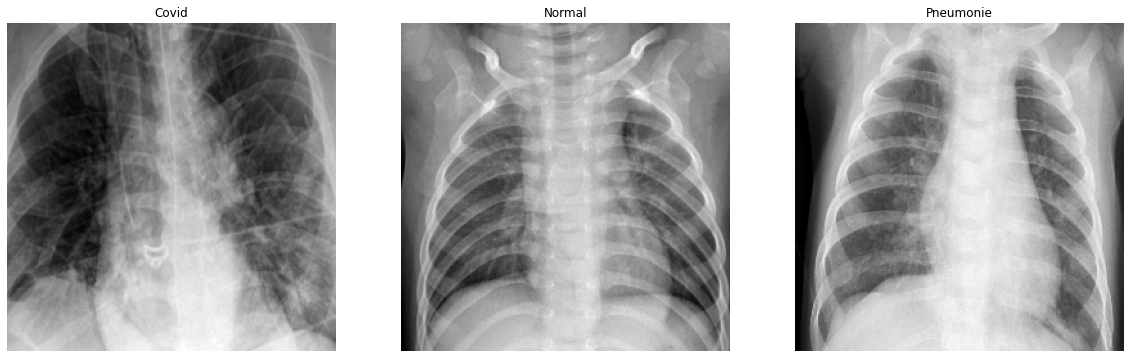

In [9]:
affichage_radio(df)

En effectuant, un tirage aléatoire dans chaque catégories de radiographie, on constate que les clichés ne présentent plus ces bandes noires qui pouvaient induire en erreur un modèle de classification.
Les images redimensionnées ont une taille de 256x256.

##### ---------------------------------------------------------------------------------------------------------------
# PARTIE 2: MODELISATIONS
##### ---------------------------------------------------------------------------------------------------------------

### Identification des variables et de la cible

Les radiographies constituent les données, la cible est défine par la classe d'appartenance des radiographies. (Covid, Normal, Pneumonie) 

In [11]:
features = [cv2.imread(df['filepath'][k]) for k in range(df.shape[0])]
target = df["label"]

### Génération d'un jeu d'entrainement et d'un jeu de test

80% du jeu de donnée total se trouve dans le jeu de données d'entrainement et 20% dans le jeu de test.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(features, target, train_size=0.8, random_state=1)

### Normalisation du jeu de données d'entrainement

Les pixels des radiographies doivent être normalisées afin d'optimiser la performance des modèles de Deep Learning.

In [13]:
X_train=np.array(X_train)/255 

### Normalisation du jeu de données de test

In [14]:
X_test=np.array(X_test)/255

### Encodage de la variable cible

Les classes doivent être encodées afin d'optimiser la performance des modèles de Deep Learning.

In [15]:
y_train_categorial = np_utils.to_categorical(y_train)
y_test_categorial = np_utils.to_categorical(y_test)

### Fonction d'affichage des résultats

##### Classification report

Cette fonction permet l'affichage du rapport de classification.

In [34]:
def classification(y_pred,y_test):
    
    report = classification_report(y_test, y_pred, target_names=list(df['nameLabel'].unique()))
    print(report)

##### Confusion matrix

Cette fonction permet l'affichage de la matrice de confusion.

In [35]:
def confusion(y_pred,y_test):
    
    cm=confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest',cmap='Blues')
    plt.title("Matrice de confusion")
    plt.colorbar() 
    tick_marks = np.arange(len(list(df['nameLabel'].unique())))
    plt.xticks(tick_marks, list(df['nameLabel'].unique()))
    plt.yticks(tick_marks, list(df['nameLabel'].unique()))
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > ( cm.max() / 2) else "black")
    plt.ylabel('Vrais labels')
    plt.xlabel('Labels prédits')

##### Courbes de précision et de perte

Cette fonction permet l'affichage des courbes de précision et de perte sur les données d'entrainement et sur les données de test.

In [36]:
def precision_perte(history):
    
    train_acc = history.history["accuracy"]
    valid_acc = history.history["val_accuracy"]
    
    plt.figure(figsize=(20,8))
    
    plt.subplot(1,2,1)
    plt.plot(np.arange(1,len(train_acc)+1), train_acc)
    plt.plot(np.arange(1,len(train_acc)+1), valid_acc)
    plt.legend(["Training Accuracy", "Validation Accuracy"])
    plt.title("Training et Validation Accuracy")
    plt.grid()
    plt.xlim([1,len(train_acc)]);
    plt.xlabel("Epoch");
    
    plt.subplot(1,2,2)
    train_loss = history.history["loss"]
    valid_loss = history.history["val_loss"]
    plt.plot(np.arange(1,len(train_loss)+1), train_loss)
    plt.plot(np.arange(1,len(train_loss)+1), valid_loss)
    plt.legend(["Training loss", "Validation loss"])
    plt.title("Training et Validation loss")
    plt.grid()
    plt.xlim([1,len(train_loss)]);
    plt.xlabel("Epoch");

##### Fonction d'affichage

Cette fonction permet la synthèse des 3 fonctions précédentes en permettant l'affichage du rapport de classifiaction, de la matrice de confusion, des courbes de précisions et de pertes.

In [37]:
def affichage(y_pred,y_test,history):
    classification(y_pred,y_test)
    confusion(y_pred,y_test)
    precision_perte(history)

# MODELISATION 1 : CNN LeNet

Cette première modélisation fait appel à une architecture basée sur "LeNet", un réseau de neurones convolutifs, caractérisé par une alternance de couche de convolution et de pooling, permettant l'extraction des caractéristiques des radiographies. En sortie, la classification est assurée par une couche dense de réseau de neurones connectés.

### Architecture du modèle

In [73]:
model = Sequential()

# couche de convulotion+pooling
model.add(Conv2D(filters = 30,
                 kernel_size = (5,5),
                 input_shape=(256,256,3), 
                 activation = 'relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters = 16,
                 kernel_size = (3,3),
                 activation = 'relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

# dropout pour éviter l'overfitting
model.add(Dropout(rate=0.2))

model.add(Flatten())

# couche de neurones complètement connectés
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

### Résumé du CNN 

In [74]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 252, 252, 30)      2280      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 126, 126, 30)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 124, 124, 16)      4336      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 62, 62, 16)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 62, 62, 16)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 61504)             0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)              

### Compilation du modèle

In [75]:
model.compile(optimizer='adam', loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [77]:
def decreasinglrUpdate(epoch,learning_rate):
    
    if epoch % 3 == 0:
        return learning_rate * 0.1
    else: 
        return learning_rate
    
lrScheduler = callbacks.LearningRateScheduler(schedule = decreasinglrUpdate, verbose = 1)

### Entrainement du modèle

In [78]:
epochs=10
batch_size=32

history = model.fit(X_train, y_train_categorial, validation_split=0.2, epochs=epochs, batch_size=batch_size,callbacks=[lrScheduler])

Epoch 1/10

Epoch 00001: LearningRateScheduler reducing learning rate to 0.00010000000474974513.
77/77 [==============================] - 55s 710ms/step - loss: 0.9474 - accuracy: 0.5447 - val_loss: 0.6587 - val_accuracy: 0.6591
Epoch 2/10

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00010000000474974513.
77/77 [==============================] - 53s 689ms/step - loss: 0.3693 - accuracy: 0.8612 - val_loss: 0.3533 - val_accuracy: 0.8564
Epoch 3/10

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00010000000474974513.
77/77 [==============================] - 52s 675ms/step - loss: 0.2602 - accuracy: 0.9037 - val_loss: 0.2399 - val_accuracy: 0.9054
Epoch 4/10

Epoch 00004: LearningRateScheduler reducing learning rate to 1.0000000474974514e-05.
77/77 [==============================] - 52s 678ms/step - loss: 0.2123 - accuracy: 0.9340 - val_loss: 0.2189 - val_accuracy: 0.9152
Epoch 5/10

Epoch 00005: LearningRateScheduler reducing learning rate to 1.000000065

### Affichage des résultats

              precision    recall  f1-score   support

       Covid       0.93      0.92      0.92       241
      Normal       0.92      0.91      0.91       269
   Pneumonie       0.87      0.89      0.88       256

    accuracy                           0.91       766
   macro avg       0.91      0.91      0.91       766
weighted avg       0.91      0.91      0.91       766



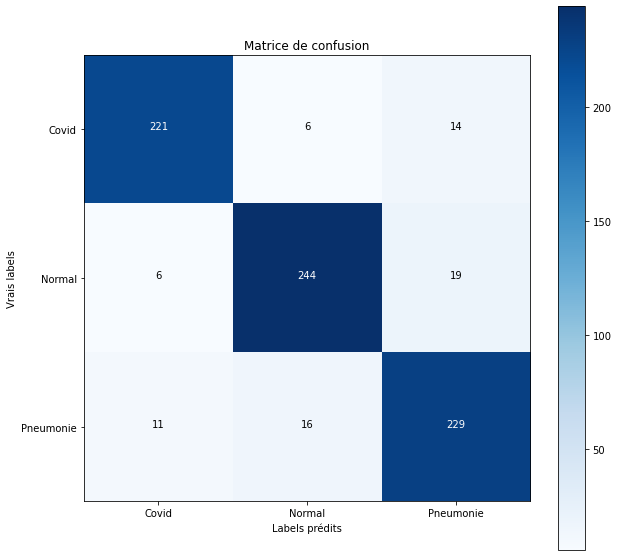

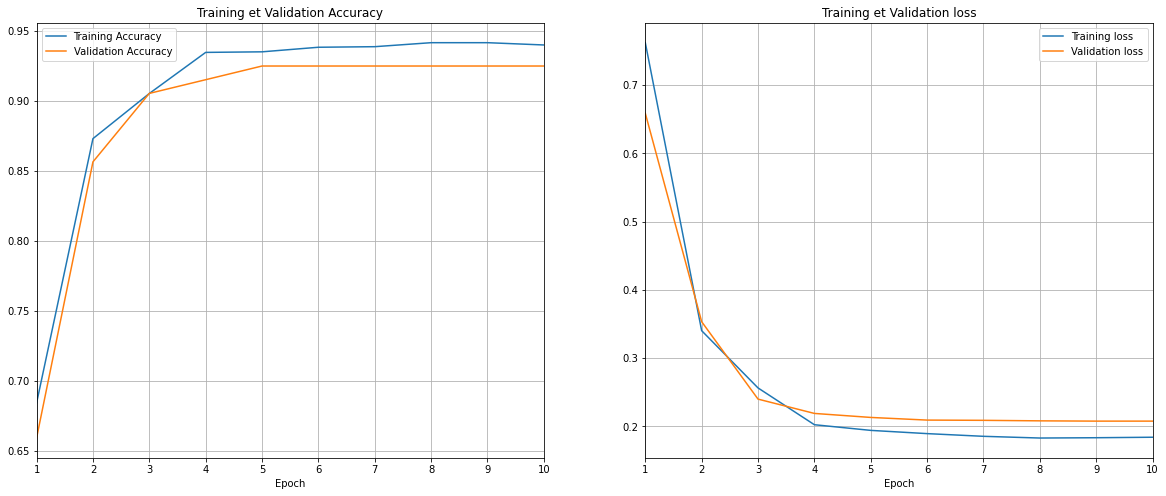

In [79]:
y_pred = np.argmax(model.predict(X_test),axis=1)
y_test = np.argmax(y_test_categorial,axis=1)

affichage(y_pred,y_test,history)

# Bilan de la MODELISATION 1: CNN LeNet
Les scores de précision et de rappel sont bons pour toutes les classes, meilleurs pour la classe COVID que pour la classe Pneumonie.\
La fonction de perte sur les données de validation converge vers un minimum.  

# MODELISATION 2: CNN personnalisé

Cet deuxième modélisation est un modèle personnalisé par l'équipe, caractérisé par une alternance de couche de convolution et de pooling, permettant l'extraction des caractéristiques des radiographies. La classification est assurée par une couche dense de réseau de neurones connectés.

### Architecture du modèle

In [80]:
model = Sequential()

# couche de convolution
model.add(Conv2D(filters=64, kernel_size=3, padding="same", activation="relu", input_shape=[256, 256, 3]))
model.add(MaxPooling2D(pool_size=2, padding="same"))
model.add(Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=2, padding="same"))
model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.05))

# couche de neurone complètement connéctées
model.add(Dense(units=32, activation ="relu"))
model.add(Dense(units=16, activation ="relu"))
model.add(Dense(units=3, activation='softmax'))

### Résumé du modèle

In [81]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 256, 256, 64)      1792      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 128, 128, 32)      18464     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_22 (Dense)             (None, 64)                8388672   
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)               

### Compilation du modèle

In [82]:
model.compile(optimizer='adam', loss = CategoricalCrossentropy(), metrics=['accuracy'])

### Entrainement du modèle

In [83]:
epochs = 10
batch_size = 32
history = model.fit(X_train, y_train_categorial, validation_split=0.2, epochs=epochs, batch_size=batch_size, callbacks=[lrScheduler])

Epoch 1/10

Epoch 00001: LearningRateScheduler reducing learning rate to 0.00010000000474974513.
77/77 [==============================] - 85s 1s/step - loss: 0.9405 - accuracy: 0.4971 - val_loss: 0.4822 - val_accuracy: 0.8287
Epoch 2/10

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00010000000474974513.
77/77 [==============================] - 83s 1s/step - loss: 0.4612 - accuracy: 0.8244 - val_loss: 0.3342 - val_accuracy: 0.8630
Epoch 3/10

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00010000000474974513.
77/77 [==============================] - 84s 1s/step - loss: 0.3447 - accuracy: 0.8691 - val_loss: 0.2978 - val_accuracy: 0.8940
Epoch 4/10

Epoch 00004: LearningRateScheduler reducing learning rate to 1.0000000474974514e-05.
77/77 [==============================] - 84s 1s/step - loss: 0.2556 - accuracy: 0.9143 - val_loss: 0.2469 - val_accuracy: 0.8972
Epoch 5/10

Epoch 00005: LearningRateScheduler reducing learning rate to 1.0000000656873453e-05.

### Affichage des résultats

In [84]:
y_pred = np.argmax(model.predict(X_test), axis=1)
y_test = np.argmax(y_test_categorial, axis=1)

              precision    recall  f1-score   support

       Covid       0.92      0.93      0.92       241
      Normal       0.91      0.91      0.91       269
   Pneumonie       0.88      0.87      0.88       256

    accuracy                           0.90       766
   macro avg       0.90      0.90      0.90       766
weighted avg       0.90      0.90      0.90       766



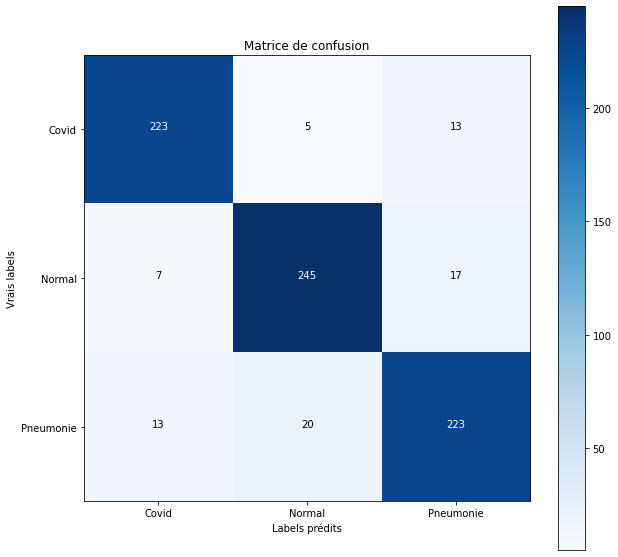

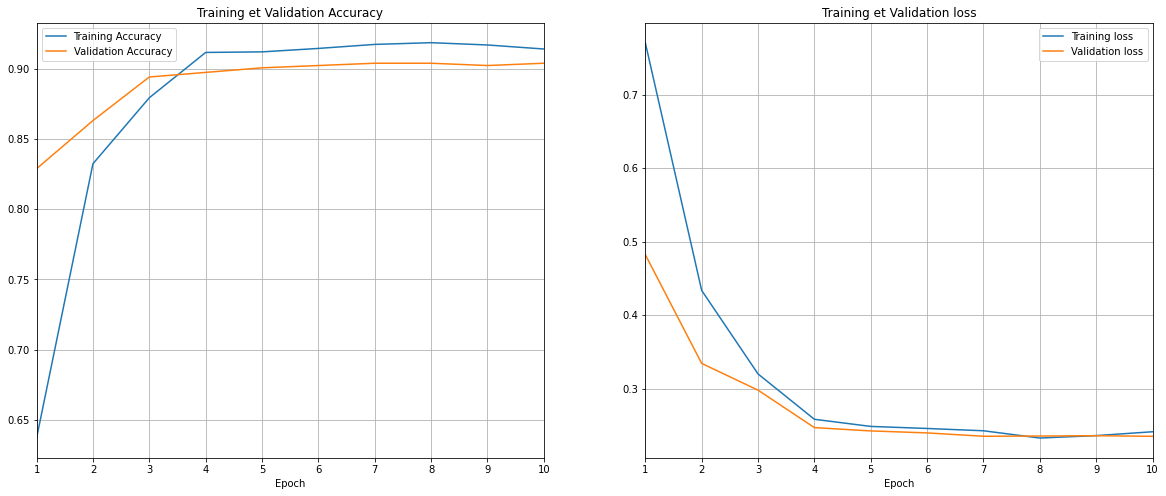

In [85]:
affichage(y_pred, y_test,history)

# Bilan de la MODELISATION 2: CNN personnalisé
Les scores de précision et de rappel sont bons pour toutes les classes, meilleurs pour la classe COVID que pour la classe Pneumonie.\
La fonction de perte sur les données de validation converge vers un minimum.  

# MODELISATION 3: Transfer Learning avec EfficientNetB5

Cette troisième modélisation est basée sur le principe du transfer learning qui consiste à utiliser un modèle pré-entrainé sur des centaines de milliers d'image. Le modèle pré-entrainé choisi est EfficientNetB5, il permet l'extraction des caractéristiques des radiographies. La classification est assurée par une couche dense de réseau de neurones connectés.

### Chargement du modèle pré-entrainé EfficientNetB5

In [19]:
from keras_efficientnets import EfficientNetB5

base_model = EfficientNetB5(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

### Résumé de EfficientNetB5

In [23]:
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 48) 192         conv2d[0][0]                     
__________________________________________________________________________________________________
swish (Swish)                   (None, 128, 128, 48) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

### Couches de convolution de EfficientNetB5  "freezer"

In [24]:
for layer in base_model.layers:
    layer.trainable = False 

### Ajout des couches de convolution de EfficientNetB5

In [25]:
model=Sequential()
model.add(base_model)

### Ajout des couches de classification fully connected

In [26]:
model.add(GlobalAveragePooling2D())
model.add(Dense(1024,activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(3, activation='softmax'))

### Résumé du CNN 

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 8, 8, 2048)        28513520  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                

### Compilation du modèle

In [28]:
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

### Entrainement du modèle

In [29]:
epoch = 10
batch_size = 32

history = model.fit(X_train, y_train_categorial, validation_split=0.2, epochs=epoch, batch_size=batch_size) 

Epoch 1/10
77/77 [==============================] - 330s 4s/step - loss: 0.4094 - accuracy: 0.8223 - val_loss: 0.1885 - val_accuracy: 0.9331
Epoch 2/10
77/77 [==============================] - 303s 4s/step - loss: 0.1549 - accuracy: 0.9435 - val_loss: 0.2196 - val_accuracy: 0.9233
Epoch 3/10
77/77 [==============================] - 299s 4s/step - loss: 0.1382 - accuracy: 0.9521 - val_loss: 0.2029 - val_accuracy: 0.9331
Epoch 4/10
77/77 [==============================] - 292s 4s/step - loss: 0.1139 - accuracy: 0.9536 - val_loss: 0.1690 - val_accuracy: 0.9527
Epoch 5/10
77/77 [==============================] - 296s 4s/step - loss: 0.1203 - accuracy: 0.9573 - val_loss: 0.1814 - val_accuracy: 0.9494
Epoch 6/10
77/77 [==============================] - 293s 4s/step - loss: 0.0765 - accuracy: 0.9701 - val_loss: 0.1646 - val_accuracy: 0.9462
Epoch 7/10
77/77 [==============================] - 296s 4s/step - loss: 0.1028 - accuracy: 0.9553 - val_loss: 0.1507 - val_accuracy: 0.9576
Epoch 8/10
77

## Fine tuning

Le fine tuning permet d'adapter les 3 dernières couches de convolutions du modèles pré-entrainé, à nos données. Ce réglage fin permet un recalcul des poids synaptiques et donc une meilleure extraction des caractéristiques des radiographies.

### 'Unfreeze' des 3 dernières couches de convolutions de EfficientNetB5

In [30]:
for layer in base_model.layers[-3:]:
    layer.trainable = True

### Nouvelle compilation du modèle

In [31]:
model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy',metrics=['accuracy'])

### Nouvel entrainement du modèle

In [32]:
epoch = 10
batch_size = 32

history = model.fit(X_train, y_train_categorial, validation_split=0.2, epochs=epoch, batch_size=batch_size) 

Epoch 1/10
77/77 [==============================] - 317s 4s/step - loss: 0.3711 - accuracy: 0.9481 - val_loss: 0.2012 - val_accuracy: 0.9494
Epoch 2/10
77/77 [==============================] - 299s 4s/step - loss: 0.0378 - accuracy: 0.9861 - val_loss: 0.1759 - val_accuracy: 0.9543
Epoch 3/10
77/77 [==============================] - 298s 4s/step - loss: 0.0506 - accuracy: 0.9807 - val_loss: 0.2030 - val_accuracy: 0.9543
Epoch 4/10
77/77 [==============================] - 298s 4s/step - loss: 0.0291 - accuracy: 0.9879 - val_loss: 0.2134 - val_accuracy: 0.9560
Epoch 5/10
77/77 [==============================] - 299s 4s/step - loss: 0.0185 - accuracy: 0.9946 - val_loss: 0.2004 - val_accuracy: 0.9543
Epoch 6/10
77/77 [==============================] - 298s 4s/step - loss: 0.0309 - accuracy: 0.9881 - val_loss: 0.2520 - val_accuracy: 0.9494
Epoch 7/10
77/77 [==============================] - 302s 4s/step - loss: 0.0262 - accuracy: 0.9906 - val_loss: 0.2005 - val_accuracy: 0.9625
Epoch 8/10
77

### Affichage des résultats

In [33]:
y_pred = np.argmax(model.predict(X_test),axis=1)
y_test = np.argmax(y_test_categorial,axis=1)

              precision    recall  f1-score   support

       Covid       0.97      0.98      0.97       241
      Normal       0.96      0.92      0.94       269
   Pneumonie       0.91      0.95      0.93       256

    accuracy                           0.95       766
   macro avg       0.95      0.95      0.95       766
weighted avg       0.95      0.95      0.95       766



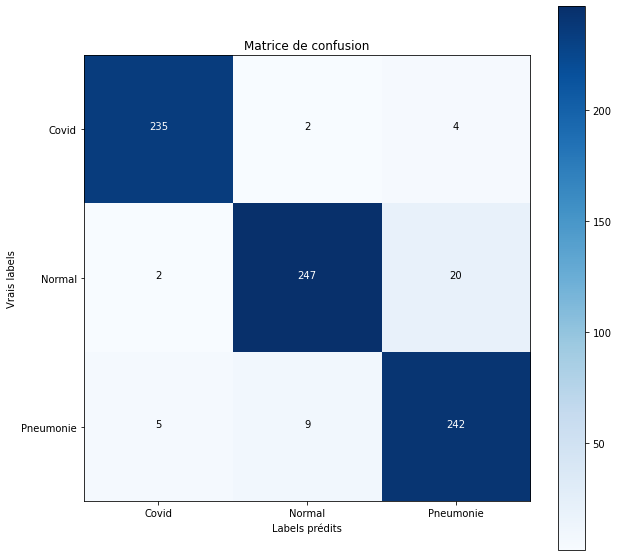

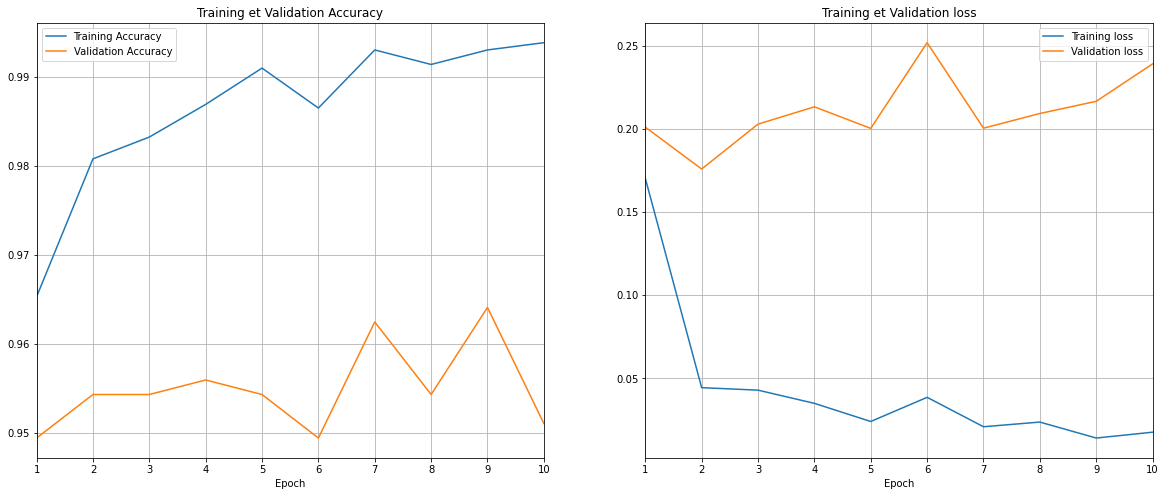

In [34]:
affichage(y_pred, y_test,history)

# Bilan de la MODELISATION 3: Transfer Learning avec EfficientNetB5
Les scores de précision et de rappel sont excellents pour la classe COVID.\
La fonction de perte sur les données de validation éprouve des difficulté à converger vers un minimum, tandis que la fonction de perte sur les données d'entrainement converge vers un minimum.\
Un phénomène d'overfitting pourrait expliquer le comportement divergeant des fonctions de pertes.\
Il serait intéressant de procéder à une augmentation d'image afin d'enrichir le jeu de données et ainsi de réduire le phénomène de sur-apprentissage.

 # MODELISATION 4: FEATURE EXTRACTION

Cette quatrième modélisation combine les techniques de deep learning et de machine learning classique. Un modèle pré-entrainé, InceptionV3, est utilisé pour extraire les caractéristiques des radiographies et un XGBoostClassifier est utilisé pour opérer la classification en sortie du modèle pré-entrainé. 

### Chargement du modèle pré-entrainé InceptionV3

In [21]:
from keras.applications.inception_v3 import InceptionV3

base_model = InceptionV3(input_shape=(256,256,3), weights='imagenet', include_top=False)

### Résumé de InceptionV3

In [22]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 127, 127, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 127, 127, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 127, 127, 32) 0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

### Couches de convolution de InceptionV3  "freezer"

In [23]:
for layer in base_model.layers:
    layer.trainable = False 

### Ajout des couches de convolution de InceptionV3

In [24]:
model=Sequential()
model.add(base_model)

### Ajout des couches de classification fully connected

In [25]:
model.add(GlobalAveragePooling2D())
model.add(Dense(1024,activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(3, activation='softmax'))

### Résumé du CNN 

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                

### Compilation du modèle

In [27]:
model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy',metrics=['accuracy'])

### Entrainement du modèle

In [28]:
epoch = 10
batch_size = 32
 
history = model.fit(X_train, y_train_categorial, validation_split=0.2, epochs=epoch, batch_size=batch_size) 

Epoch 1/10
77/77 [==============================] - 109s 1s/step - loss: 0.6404 - accuracy: 0.6983 - val_loss: 0.2606 - val_accuracy: 0.9201
Epoch 2/10
77/77 [==============================] - 100s 1s/step - loss: 0.2498 - accuracy: 0.8981 - val_loss: 0.2173 - val_accuracy: 0.9135
Epoch 3/10
77/77 [==============================] - 102s 1s/step - loss: 0.1884 - accuracy: 0.9348 - val_loss: 0.1929 - val_accuracy: 0.9233
Epoch 4/10
77/77 [==============================] - 100s 1s/step - loss: 0.2045 - accuracy: 0.9204 - val_loss: 0.1768 - val_accuracy: 0.9347
Epoch 5/10
77/77 [==============================] - 100s 1s/step - loss: 0.1448 - accuracy: 0.9440 - val_loss: 0.1678 - val_accuracy: 0.9413
Epoch 6/10
77/77 [==============================] - 101s 1s/step - loss: 0.1304 - accuracy: 0.9468 - val_loss: 0.1585 - val_accuracy: 0.9462
Epoch 7/10
77/77 [==============================] - 102s 1s/step - loss: 0.1032 - accuracy: 0.9632 - val_loss: 0.1623 - val_accuracy: 0.9429
Epoch 8/10
77

### Connexion aux dernières couches du modèle

In [29]:
intermediate_layer_model = Model(model.input, model.layers[2].output)
X_train_feature = intermediate_layer_model.predict(preprocess_input(X_train))
X_test_feature = intermediate_layer_model.predict(preprocess_input(X_test))

### Affichage des résultats

In [30]:
xgb = XGBClassifier()
xgb.fit(X_train_feature, np.argmax(y_train_categorial, axis=1))

[18:20:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [31]:
print('score:', xgb.score(X_test_feature, np.argmax(y_test_categorial, axis=1)))

score: 0.933420365535248


In [32]:
y_pred = xgb.predict(X_test_feature)
y_test = np.argmax(y_test_categorial,axis=1)

              precision    recall  f1-score   support

       Covid       0.98      0.98      0.98       241
      Normal       0.91      0.93      0.92       269
   Pneumonie       0.92      0.89      0.91       256

    accuracy                           0.93       766
   macro avg       0.93      0.93      0.93       766
weighted avg       0.93      0.93      0.93       766



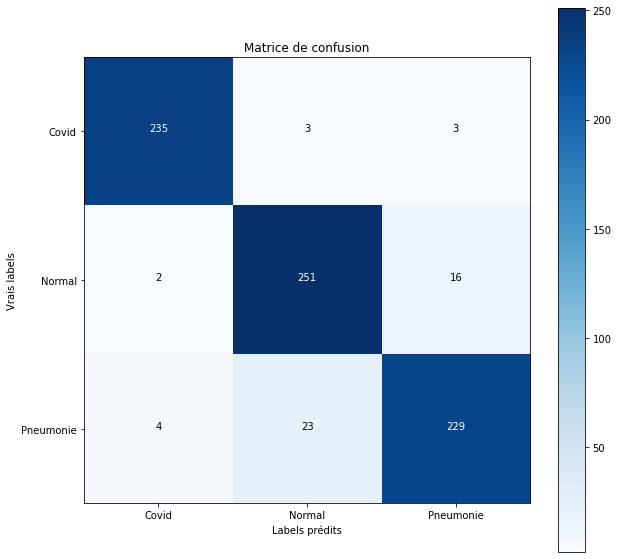

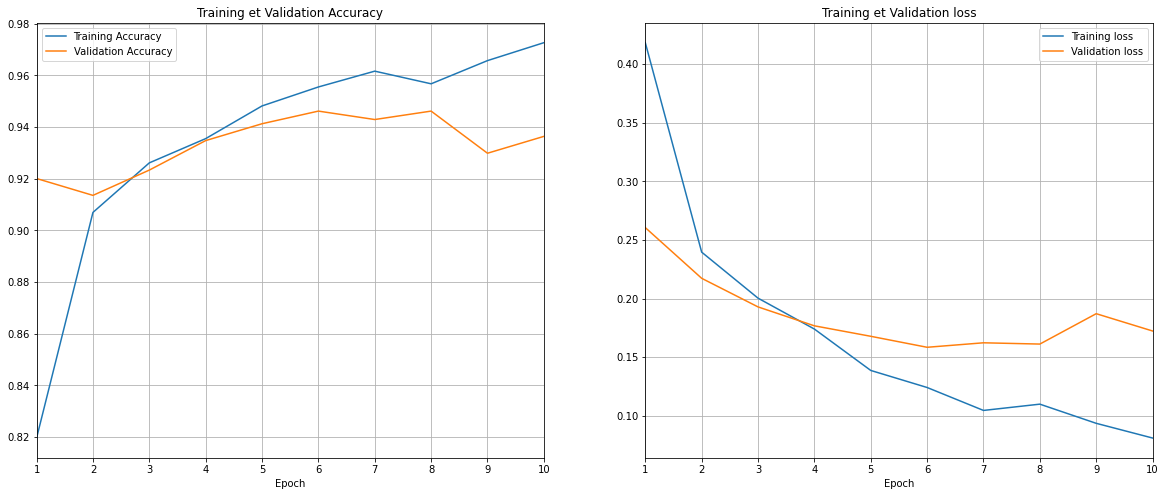

In [38]:
affichage(y_pred, y_test, history)

# Bilan de la MODELISATION 4: Feature extraction
Les scores de précision et de rappel sont bons pour toutes les classes, meilleurs pour la classe COVID que pour les classes Normal et Pneumonie.\
La fonction de perte sur les données de validation semble converger vers un minimum.  

# MODELISATION 5: Augmentation d'image avec VGG16

Cette dernière modélisation utilise la technique d'augmentation d'image qui permet d'enrichir le jeu de données et de réduire le phénomène d'overfitting. VGG16, un modèle pré-entrainé, est utlisé pour extraire les caractéristiques des radiographies. La classification est assurée par une couche dense de réseau de neurones connectés.

In [70]:
features=df["filepath"]
target=df["label"]

In [71]:
X_train, X_test, y_train, y_test = train_test_split(features, target, train_size=0.8, random_state=1)

### DataFrame du jeu de données d'entrainement

In [72]:
X_train = pd.DataFrame(X_train)
X_train = list(map(lambda x : [x, x.split('\\')[5]], X_train["filepath"]))

In [73]:
data_train = pd.DataFrame(X_train, columns=['filepath', 'nameLabel'])
data_train['label'] = data_train['nameLabel'].replace(data_train.nameLabel.unique(), [*range(len(data_train.nameLabel.unique()))])
data_train

,filepath,nameLabel,label
0,C:\Users\cedric\Desktop\Projet\Covid\Covid_521...,Covid,0
1,C:\Users\cedric\Desktop\Projet\Normal\Normal_1...,Normal,1
2,C:\Users\cedric\Desktop\Projet\Normal\Normal_7...,Normal,1
3,C:\Users\cedric\Desktop\Projet\Pneumonie\Pneum...,Pneumonie,2
4,C:\Users\cedric\Desktop\Projet\Normal\Normal_1...,Normal,1
...,...,...,...
3058,C:\Users\cedric\Desktop\Projet\Pneumonie\Pneum...,Pneumonie,2
3059,C:\Users\cedric\Desktop\Projet\Covid\Covid_785...,Covid,0
3060,C:\Users\cedric\Desktop\Projet\Covid\Covid_957...,Covid,0
3061,C:\Users\cedric\Desktop\Projet\Covid\Covid_181...,Covid,0


### DataFrame du jeu de données de test

In [74]:
X_test=pd.DataFrame(X_test)

In [75]:
X_test = list(map(lambda x : [x, x.split('\\')[5]], X_test["filepath"]))

In [76]:
data_test = pd.DataFrame(X_test, columns=['filepath', 'nameLabel'])
data_test['label'] = data_test['nameLabel'].replace(data_train.nameLabel.unique(), [*range(len(data_train.nameLabel.unique()))])
data_test 

,filepath,nameLabel,label
0,C:\Users\cedric\Desktop\Projet\Normal\Normal_2...,Normal,1
1,C:\Users\cedric\Desktop\Projet\Covid\Covid_101...,Covid,0
2,C:\Users\cedric\Desktop\Projet\Normal\Normal_1...,Normal,1
3,C:\Users\cedric\Desktop\Projet\Pneumonie\Pneum...,Pneumonie,2
4,C:\Users\cedric\Desktop\Projet\Pneumonie\Pneum...,Pneumonie,2
...,...,...,...
761,C:\Users\cedric\Desktop\Projet\Pneumonie\Pneum...,Pneumonie,2
762,C:\Users\cedric\Desktop\Projet\Covid\Covid_986...,Covid,0
763,C:\Users\cedric\Desktop\Projet\Normal\Normal_6...,Normal,1
764,C:\Users\cedric\Desktop\Projet\Normal\Normal_1...,Normal,1


### Augmentation d'image

In [77]:
from keras_preprocessing.image import ImageDataGenerator

train_data_generator = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 5,
    zoom_range = 0.01,
    validation_split=0.25,  
)

test_data_generator = ImageDataGenerator(
    rescale = 1./255
)   

### Génération des données d'entrainement

In [78]:
data_train["label"] = data_train["label"].astype(str)

train_generator = train_data_generator.flow_from_dataframe(
    dataframe=data_train, 
    x_col='filepath',
    y_col='label',
    shuffle=True,
    class_mode='categorical',
    subset='training'   
)

print("Le train set contient {} radiographies".format(train_generator.samples))

Found 2298 validated image filenames belonging to 3 classes.
Le train set contient 2298 radiographies


### Génération des données de validation

In [79]:
data_train["label"] = data_train["label"].astype(str)

valid_generator = train_data_generator.flow_from_dataframe(
    dataframe=data_train, 
    x_col='filepath',
    y_col='label',
    shuffle=True,
    class_mode='categorical',
    subset='validation'
)

print("Le validation set contient {} radiographies".format(valid_generator.samples))

Found 765 validated image filenames belonging to 3 classes.
Le validation set contient 765 radiographies


### Génération des données de test 

In [80]:
data_test["label"] = data_test["label"].astype(str)

test_generator = test_data_generator.flow_from_dataframe(
    dataframe=data_test, 
    x_col='filepath',
    y_col=None,
    class_mode=None,
    shuffle=False
)

print("Le test set contient {} images".format(test_generator.samples))

Found 766 validated image filenames.
Le test set contient 766 images


### Mise en place d'un modèle pré-entrainé VGG16

In [81]:
base_model = VGG16(input_shape=(256,256,3),weights='imagenet', include_top=False)

### Couches de convolution de VGG16  "freezer"

In [82]:
for layer in base_model.layers:
    layer.trainable = False 

### Résumé du modèle

In [83]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

### Ajout des couches de convolution de VGG16

In [84]:
model=Sequential()
model.add(base_model)

### Ajout des couches de classification fully connected

In [85]:
model.add(GlobalAveragePooling2D())
model.add(Dense(1024,activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(3, activation='softmax'))

### Compilation du modèle

In [86]:
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

### Entrainement du modèle

In [88]:
epoch = 10
batch_size = 32

history = model.fit_generator(
    generator=train_generator,
    epochs = epoch,
    steps_per_epoch = train_generator.samples//batch_size,
    validation_data = valid_generator,
    validation_steps = valid_generator.samples//batch_size
) 

Epoch 1/10
71/71 [==============================] - 296s 4s/step - loss: 0.5444 - accuracy: 0.7749 - val_loss: 0.2708 - val_accuracy: 0.8967
Epoch 2/10
71/71 [==============================] - 294s 4s/step - loss: 0.2618 - accuracy: 0.9047 - val_loss: 0.2352 - val_accuracy: 0.9022
Epoch 3/10
71/71 [==============================] - 292s 4s/step - loss: 0.2426 - accuracy: 0.9095 - val_loss: 0.2099 - val_accuracy: 0.9212
Epoch 4/10
71/71 [==============================] - 298s 4s/step - loss: 0.2170 - accuracy: 0.9135 - val_loss: 0.2465 - val_accuracy: 0.8872
Epoch 5/10
71/71 [==============================] - 298s 4s/step - loss: 0.1828 - accuracy: 0.9285 - val_loss: 0.1134 - val_accuracy: 0.9647
Epoch 6/10
71/71 [==============================] - 292s 4s/step - loss: 0.1841 - accuracy: 0.9298 - val_loss: 0.1376 - val_accuracy: 0.9497
Epoch 7/10
71/71 [==============================] - 292s 4s/step - loss: 0.1782 - accuracy: 0.9250 - val_loss: 0.1223 - val_accuracy: 0.9565
Epoch 8/10
71

## Fine tuning

Le fine tuning permet d'adapter 4 les dernières couches de convolutions du modèle pré-entrainé, à nos données. Ce réglage fin permet une meilleur extraction des caractéristiques des radiographies. 

### 'Unfreeze' des 4 dernières couches de convolutions de VGG16

In [89]:
for layer in base_model.layers[-4:]:
    layer.trainable = True

### Nouvelle compilation du modèle

In [90]:
model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy',metrics=['accuracy'])

### Nouvel entrainement du modèle

In [91]:
epoch = 10
batch_size = 32

history = model.fit_generator(
    generator=train_generator,
    epochs = epoch,
    steps_per_epoch = train_generator.samples//batch_size,
    validation_data = valid_generator,
    validation_steps = valid_generator.samples//batch_size
) 

Epoch 1/10
71/71 [==============================] - 338s 5s/step - loss: 1.3092 - accuracy: 0.6876 - val_loss: 0.1544 - val_accuracy: 0.9511
Epoch 2/10
71/71 [==============================] - 335s 5s/step - loss: 0.1710 - accuracy: 0.9387 - val_loss: 0.1165 - val_accuracy: 0.9565
Epoch 3/10
71/71 [==============================] - 349s 5s/step - loss: 0.1076 - accuracy: 0.9580 - val_loss: 0.0979 - val_accuracy: 0.9633
Epoch 4/10
71/71 [==============================] - 348s 5s/step - loss: 0.1045 - accuracy: 0.9632 - val_loss: 0.1312 - val_accuracy: 0.9457
Epoch 5/10
71/71 [==============================] - 335s 5s/step - loss: 0.0822 - accuracy: 0.9686 - val_loss: 0.0901 - val_accuracy: 0.9701
Epoch 6/10
71/71 [==============================] - 343s 5s/step - loss: 0.0579 - accuracy: 0.9821 - val_loss: 0.0737 - val_accuracy: 0.9688
Epoch 7/10
71/71 [==============================] - 345s 5s/step - loss: 0.0537 - accuracy: 0.9817 - val_loss: 0.1419 - val_accuracy: 0.9524
Epoch 8/10
71

### Affichage des nouveaux résultats

In [92]:
test_generator.reset()
y_pred = np.argmax(model.predict_generator(test_generator),axis=1)
y_test=data_test["label"].astype(int)

              precision    recall  f1-score   support

       Covid       1.00      0.98      0.99       241
      Normal       0.94      0.98      0.96       269
   Pneumonie       0.96      0.95      0.95       256

    accuracy                           0.97       766
   macro avg       0.97      0.97      0.97       766
weighted avg       0.97      0.97      0.97       766



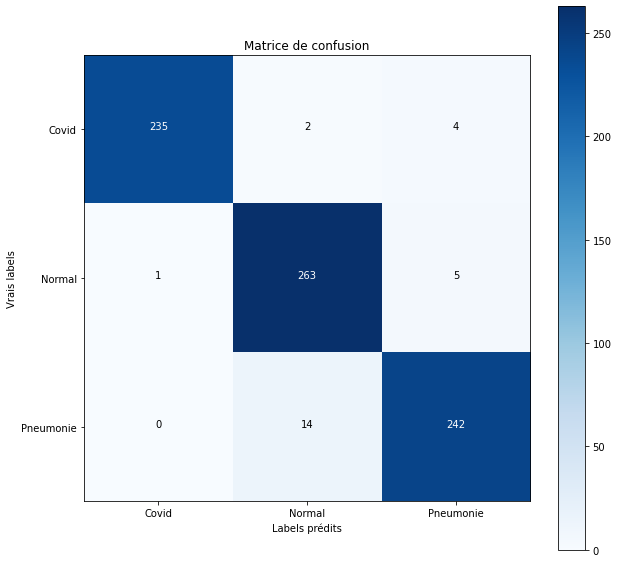

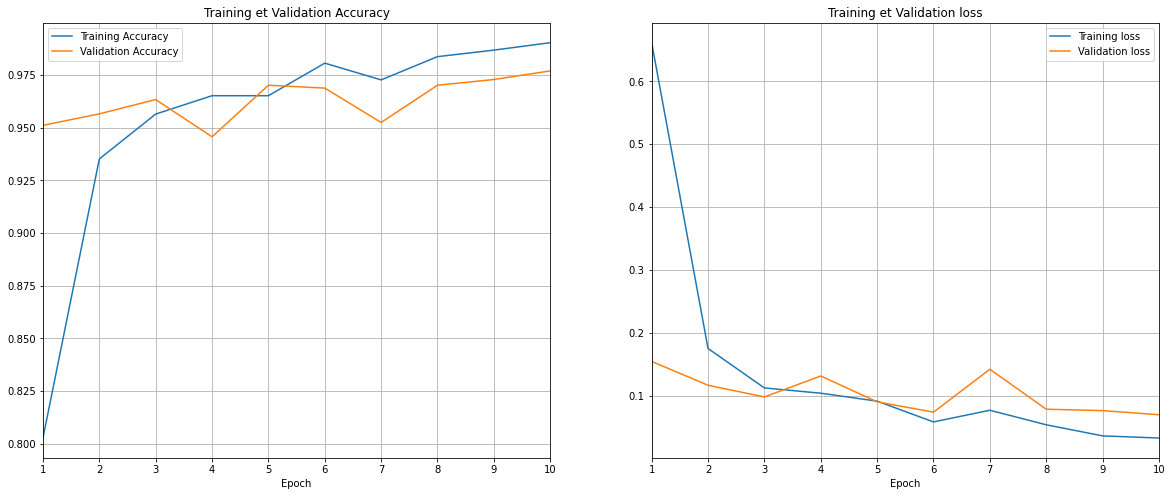

In [93]:
affichage(y_pred, y_test, history)

# Bilan de la MODELISATION 5: Augmentation d'image avec VGG16
Les scores de précision et de rappel sont excellents pour toutes les classes.\
La fonction de perte sur les données de validation converge vers un minimum. 

# CONCLUSION

Dans l'ensemble, les 5 modèles testés donnent de très bons résultats.\
La sensibilité et la valeure prédictive positive sont élevées pour toutes les classes, en particuliers pour la classe COVID.

La plupart des modèles testés, présentent une sensibilité d'au moins 98% sur la classe COVID, par conséquent, le taux de faux négatif est extrêmement faible.\
L'analyse de cliché radiographique à l'aide d'un modèle basé sur des CNN est donc très fiable pour exclure la présence de la maladie chez un patient.